# Statistical Language Modeling with NLTK

### Recommended Reading

- Dan Jurafsky and James H. Martin's __Speech and Language Processing__ ([3rd ed. draft](https://web.stanford.edu/~jurafsky/slp3/))

### Covered Material
- SLP
    - [Chapter 3: N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf) 

### Requirements

- [NLTK](https://www.nltk.org/)

## 1. Ngrams and Ngram Counting

[n-gram](https://en.wikipedia.org/wiki/N-gram) is a contiguous sequence of *n* items from a given sequence of text or speech. An n-gram model models sequences, notably natural languages, using the statistical properties of n-grams.

__Example__:

- character n-grams: mice
- word n-grams: the answer is 42


|                     | 1-gram  | 2-gram  | 3-gram  |
|---------------------|---------|---------|---------|
|                     | unigram | bigram  | trigram |
| *Markov Order*      | 0       | 1       | 2       |
| *Character N-grams* | `['m', 'i', 'c', 'e']` | `['mi', 'ic', 'ce']` | `['mic', 'ice']` | 
| *Word N-grams*      | `['the', 'answer', 'is' , '42']` | `['the answer', 'answer is', ...]` | `['the answer is', ...]` |


### 1.1. Counting Ngrams

*Frequency List* of a corpus is essentially a unigram count. Ngram count only differs in a unit of counting sequence of $n$ of tokens. 

We can compute the count by taking sequences of 2 items (bigrams), 3 items (trigrams), etc.

#### 1.1.1. Preparing Data
The required data format for ngram counting is a _list-of-lists_ (lists of sentences consisting of lists of words): 

```
[
     ['the', 'answer', 'is', '42'], 
     ['the', 'mice', 'said']
]
```

#### 1.1.2. Sentence beginning & end tags

>Including sentence boundary markers leads to a better model. To do that we need to augment each sentence with a special symbols for beginning and end of sentence tags (`<s>` and `</s>`, respectively). The beginning of the sentence (BOS) tag gives the bigram context of the first word; and encodes probability of a word to start a sentence. Adding the end of the sentence (EOS) tag, on the other hand, makes the bigram model a true probability distribution (Jurafsky and Martin). "Without it,  the sentence probabilities for all sentences of *a given length* would sum to one only. This model would define an infinite set of probability distributions, with one distribution per sentence length"

>For larger ngrams, we’ll need to assume extra context for the contexts to the left and right of the sentence boundaries. For example, to compute trigram probabilities at the very beginning of the sentence, we can use two pseudo-words for the first trigram (i.e. `['<s>', '<s>', w1]`). Alternatively, we can use [back-off](https://en.wikipedia.org/wiki/Katz%27s_back-off_model), and use the `['<s>', w1]` bigram probability. 

**Example**:
`['<s>', 'the', 'answer', 'is', '42', '</s>']`

#### 1.1.3. NLTK Utility Functions
NLTK provides utility functions for padding sequences.

In [1]:
sent = ['the', 'answer', 'is', '42']

In [2]:
from nltk.util import pad_sequence

list(pad_sequence(
        sent,  # input sequence
        pad_left=True,
        left_pad_symbol="<s>",
        pad_right=True,
        right_pad_symbol="</s>",
        n=2  # padding for bigrams
    )
)
# for a k-gram, need k-1 tokens of context

['<s>', 'the', 'answer', 'is', '42', '</s>']

Another NLTK function wraps this utility function with default arguments to provide a more convenient interface. 

In [3]:
from nltk.lm.preprocessing import pad_both_ends

list(pad_both_ends(sent, n=2))

['<s>', 'the', 'answer', 'is', '42', '</s>']

#### 1.1.4. Extracting Ngrams
NLTK provides a function to extact ngrams from a sequence, which also performs padding, if required arguments are provided.

In [4]:
from nltk.util import ngrams

list(ngrams(sent, 2))

[('the', 'answer'), ('answer', 'is'), ('is', '42')]

In [5]:
bigrams = ngrams(
    sent,
    2,
    pad_left=True,
    left_pad_symbol="<s>",
    pad_right=True,
    right_pad_symbol="</s>",
)
list(bigrams)

# here we added bi-gram padding (we can compute the bi-gram for the first token thanks to padding)

[('<s>', 'the'),
 ('the', 'answer'),
 ('answer', 'is'),
 ('is', '42'),
 ('42', '</s>')]

Additionally, NLTK provides wrapper functions to extract bigrams and trigrams.

In [6]:
from nltk.util import bigrams, trigrams

print(list(bigrams(sent)))
print(list(trigrams(sent)))

print(list(bigrams(pad_both_ends(sent, n=2))))
print(list(bigrams(sent, 
                   pad_left=True, 
                   left_pad_symbol="<s>", 
                   pad_right=True, 
                   right_pad_symbol="</s>")))

[('the', 'answer'), ('answer', 'is'), ('is', '42')]
[('the', 'answer', 'is'), ('answer', 'is', '42')]
[('<s>', 'the'), ('the', 'answer'), ('answer', 'is'), ('is', '42'), ('42', '</s>')]
[('<s>', 'the'), ('the', 'answer'), ('answer', 'is'), ('is', '42'), ('42', '</s>')]


#### 1.1.5. Extracting "Everygrams"
To make an ngram model more robust, it is usually also trained on lower-order ngrams (i.e. unigrams in case of bigrams). 
NLTK also provides utility function to extract these together.

Note the `max_len` argument that defines the maximum length of an ngram.

In [7]:
from nltk.util import everygrams

# compute all k-grams up to n
print(list(everygrams(sent, max_len=2)))
print(list(everygrams(pad_both_ends(sent, n=2), max_len=2)))

[('the',), ('the', 'answer'), ('answer',), ('answer', 'is'), ('is',), ('is', '42'), ('42',)]
[('<s>',), ('<s>', 'the'), ('the',), ('the', 'answer'), ('answer',), ('answer', 'is'), ('is',), ('is', '42'), ('42',), ('42', '</s>'), ('</s>',)]


In [8]:
all_ngrams = everygrams(
    sent,
    min_len=1,
    max_len=2,
    pad_left=True,
    left_pad_symbol="<s>",
    pad_right=True,
    right_pad_symbol="</s>"
)
list(all_ngrams)

[('<s>',),
 ('<s>', 'the'),
 ('the',),
 ('the', 'answer'),
 ('answer',),
 ('answer', 'is'),
 ('is',),
 ('is', '42'),
 ('42',),
 ('42', '</s>'),
 ('</s>',)]

#### 1.1.6. "Flattening" the Data
For language model training and evaluation (as well as vocabulary extraction) NLTK expects the data to be a flat list. 
In python, this is accomplished either by using `itertools.chain.from_iterable` or python list comprehension as

`[element for sublist in superlist for element in sublist]`

In [9]:
from itertools import chain

data = [['which', 'is', 'the', 'sense', 'of', 'life', '?'], ['the', 'answer', 'is', '42']]

list(chain.from_iterable(data))

['which', 'is', 'the', 'sense', 'of', 'life', '?', 'the', 'answer', 'is', '42']

In [10]:
# Comprehension list
[token for sent in data for token in sent]

['which', 'is', 'the', 'sense', 'of', 'life', '?', 'the', 'answer', 'is', '42']

In [11]:
from nltk.lm.preprocessing import flatten
list(flatten(data))

['which', 'is', 'the', 'sense', 'of', 'life', '?', 'the', 'answer', 'is', '42']

#### 1.1.7. Combining the Tasks
NLTK wraps both tasks:

- padded ngram (everygram) extraction from each sentence
- flat list creation

into a convenient utility function `padded_everygram_pipeline` that returns lazy iterators.

In [12]:
from nltk.lm.preprocessing import padded_everygram_pipeline

# flatten, pads and computes everygrams
padded_ngrams, flat_text = padded_everygram_pipeline(2, data)

In [13]:
for sent_ngrams in padded_ngrams:
    print(list(sent_ngrams))

[('<s>',), ('<s>', 'which'), ('which',), ('which', 'is'), ('is',), ('is', 'the'), ('the',), ('the', 'sense'), ('sense',), ('sense', 'of'), ('of',), ('of', 'life'), ('life',), ('life', '?'), ('?',), ('?', '</s>'), ('</s>',)]
[('<s>',), ('<s>', 'the'), ('the',), ('the', 'answer'), ('answer',), ('answer', 'is'), ('is',), ('is', '42'), ('42',), ('42', '</s>'), ('</s>',)]


In [14]:
list(flat_text)

['<s>',
 'which',
 'is',
 'the',
 'sense',
 'of',
 'life',
 '?',
 '</s>',
 '<s>',
 'the',
 'answer',
 'is',
 '42',
 '</s>']

**Note:** lazy iterators (aka generators) are for one-use only. 

In [15]:
padded_ngrams, flat_text = padded_everygram_pipeline(2, ['winter is coming'.split()])
print(padded_ngrams)
print([list(x) for x in padded_ngrams]) # We use the generator
print([list(x) for x in padded_ngrams]) # We lost it 
# If you want to reuse the generator you have to recompute it
padded_ngrams, flat_text = padded_everygram_pipeline(2, ['winter is coming'.split()])
print([list(x) for x in padded_ngrams])

<generator object padded_everygram_pipeline.<locals>.<genexpr> at 0x000001A0E461D9E0>
[[('<s>',), ('<s>', 'winter'), ('winter',), ('winter', 'is'), ('is',), ('is', 'coming'), ('coming',), ('coming', '</s>'), ('</s>',)]]
[]
[[('<s>',), ('<s>', 'winter'), ('winter',), ('winter', 'is'), ('is',), ('is', 'coming'), ('coming',), ('coming', '</s>'), ('</s>',)]]


### 1.2. Ngram Counter
NLTK provides NgramCounter class to do the ngram counting. The class can be initialized without any agrument and then updated with ngrams (via `update()` method); or directly initialized with ngrams.

`N()` method returns total number of ngrams stored.

In [16]:
from nltk.lm import NgramCounter

counter = NgramCounter()
counter.N()  # return total number of stored ngrams

0

In [17]:
padded_ngrams, flat_text = padded_everygram_pipeline(2, data)
counter.update(padded_ngrams)  # update counter with ngrams
counter.N()

28

In [18]:
padded_ngrams, flat_text = padded_everygram_pipeline(2, data)
counter = NgramCounter(padded_ngrams)
counter.N()

28

#### 1.2.1. Accessing Ngram Counts

Ngram counts can be accessed using standard python dictionary notation. 
- Ngram order counts can be accessed using integer keys (order)
    - returns `Frequency Distribution` or `Conditional Frequency Distribution` objects. [link](https://www.nltk.org/api/nltk.probability.html)
- Unigram counts can be accessed using string keys.
- Bigram counts can be accessed using list keys & string keys (see example)

In [19]:
# ngram order counts
print(counter[1])  # Frequency Distribution
print(counter[2])  # Conditional Frequency Distribution

<FreqDist with 11 samples and 15 outcomes>
<ConditionalFreqDist with 10 conditions>


In [20]:
# print counts
print(counter.unigrams)  # unigram count for convenience

<FreqDist with 11 samples and 15 outcomes>


In [21]:
# unigram counts
counter['the']

2

In [22]:
# 'full' bigram counts (full bigrams)
counter[['the']]['answer']

1

In [23]:
# to get a frequency distribution over all continuations, you can use list or tuple. 
# counter[['the']] or counter[('the',)]
counter[['the']]

FreqDist({'sense': 1, 'answer': 1})

In [24]:
# For Conditional Frequency Distributions, only tuples are accepted.
# counter[2][['the']] with throw an error
counter[2][('the',)]

FreqDist({'sense': 1, 'answer': 1})

### Exercise: Counting Ngrams in Shakespeare's Hamlet

- Load Shakespeare's Hamlet from Gutenberg corpus
    - lowercase it

- Extract padded unigrams and bigrams

- Using NgramCounter
    - get total number of ngrams
    - get count of unigram `the`
    - get count of bigram `of the`
    
|                     | Count  | 
|---------------------|---------|
| Ngrams      | 84038     | 
| Unigram *the* | 993|
| Bigram *of the*     |59 |

In [25]:
from nltk.corpus import gutenberg

# It returns a list of lists
hamlet = gutenberg.sents('shakespeare-hamlet.txt')

print(len(hamlet))

# lowercasing use .lower()
hamlet_lowercase = [[t.lower() for t in s] for s in hamlet] #lowercase the hamlet corpus

# double check
print(hamlet[0])
print(hamlet_lowercase[0])

3106
['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', 'William', 'Shakespeare', '1599', ']']
['[', 'the', 'tragedie', 'of', 'hamlet', 'by', 'william', 'shakespeare', '1599', ']']


In [26]:
padded_ngrams, flat_text = padded_everygram_pipeline(2, hamlet_lowercase) #use the padded every gram pipeline

In [27]:
counter = NgramCounter(padded_ngrams) # NgramCounter(X)

In [28]:
#counter[2][('<s>',)]
counter[["the"]]

FreqDist({'king': 40, 'matter': 14, 'very': 13, 'queene': 13, 'world': 13, 'players': 10, 'play': 10, 'time': 8, 'body': 8, 'which': 7, ...})

In [29]:
print(counter) # Total number of Ngrams 
print(counter["the"]) # the
print(counter[["of"]]["the"]) # of the

<NgramCounter with 2 ngram orders and 84038 ngrams>
993
59


## 2. Vocabulary and Basic Usage

[`Vocabulary`](https://www.nltk.org/api/nltk.lm.vocabulary.html) class of NLTK satisfies two common language modeling requirements for a vocabulary:
- When checking membership and calculating its size, filters items by comparing their counts to a cutoff value.
- Adds a special "unknown" token which unseen words are mapped to.

Tokens with counts greater than or equal to the cut-off value will be considered part of the vocabulary.

`Vocabulary(counts=None, unk_cutoff=1, unk_label='<UNK>)` create a new `Vocabulary`.

- `counts` (optional) iterable or collections. 
    - Counter instance to pre-seed the `Vocabulary`. 
    - In case it is iterable, counts are calculated.

- `unk_cutoff` (int) - Words that occur less frequently than this value are not considered part of the vocabulary.

- `unk_label` - Label for marking words not part of vocabulary.

In [30]:
from nltk.lm import Vocabulary
from nltk.corpus import gutenberg

hamlet_words = gutenberg.words('shakespeare-hamlet.txt')

# lowercase
hamlet_words = [w.lower() for w in hamlet_words]

# initialize vocabulary with cut-off
vocab = Vocabulary(hamlet_words, unk_cutoff=2)

`Vocabulary` methods:

- `lookup()` looks up words in a vocabulary. 
    - "Unseen" words (with counts less than cutoff) are looked up as the unknown label. 
    - If given one word (a string) as an input, this method will return a string.
    - If given a sequence, it will return an tuple of the looked up words.
    
- `update()` update counts from a sequence

`Vocabulary` properties:

- `cutoff` - same as `unk_cutoff`

- `unk_label` and `counts` can also be accessed as properties
    - `vocab.unk_label`
    - `vocab.counts`

### 2.1. Counts, Vocabulary Membership, and Lookup

Tokens with frequency counts less than the `cutoff` value will be considered not part of the vocabular, even though their entries in the count dictionary are preserved. 

This is useful for changing cut-off without recomputing counts.

In [31]:
# let's define a function to illustrate the relation between counts, membership, and lookup
def test_word(word, vocab):
    # let's lowercase it
    if word != vocab.unk_label:
        word = word.lower() 
    # membership test
    word_membership = word in vocab
    # accessing count
    word_count = vocab[word]
    # lookup
    word_lookup = vocab.lookup(word)
    
    print("Word: '{}', Count: {}, In Vocab: {}, Mapped to: '{}'".format(
        word, word_count, word_membership, word_lookup))
    

In [32]:
for w in ["<UNK>", "the", "1599", "Trento"]:
    test_word(w, vocab)

Word: '<UNK>', Count: 2, In Vocab: True, Mapped to: '<UNK>'
Word: 'the', Count: 993, In Vocab: True, Mapped to: 'the'
Word: '1599', Count: 1, In Vocab: False, Mapped to: '<UNK>'
Word: 'trento', Count: 0, In Vocab: False, Mapped to: '<UNK>'


### 2.2. Cut-Off and Vocabulary Size
The cut-off value influences not only membership checking but also the result of getting the size of the vocabulary using the built-in `len`. Note that while the number of keys in the vocabulary's counter stays the same, the items in the vocabulary differ depending on the cut-off.

In [33]:
# Let's define another vocabulary with cut-off 1
# Notice that we are passing counts from the original vocabulary
vocab1 = Vocabulary(vocab.counts, unk_cutoff=1) # with smaller cutoff >1 count, stays the same

In [34]:
# len here is the number ofunique tokens 
print("CutOff 2:", len(vocab))
print("CutOff 1:", len(vocab1))

CutOff 2: 1867
CutOff 1: 4717


In [35]:
# here cutoff is completely ignored
# len of counts is the sum of all counts (=text length)
print("CutOff 2 Counts:", len(vocab.counts))
print("CutOff 1 Counts:", len(vocab1.counts))

CutOff 2 Counts: 4716
CutOff 1 Counts: 4716


#### Exercise
- lookup in vocabulary
    - "trento is the capital city of trentino"
- update vocabulary with "trento is the capital city of trentino"
    - do the lookup again to see the effect
- experiment with changing the cut-off value from `1` to `10`
    - do the lookup again to see the effect

In [36]:
sentence = "trento is the capital city of trentino".split() # use the .split() to tokenize the sentence

# Cut-off 0 
print('Cut-off 0')
vocab = Vocabulary(hamlet_words)

# Print lookup before vocab update using vocab.lookup
print(f"Lookup of {sentence}: \n{vocab.lookup(sentence)}")

# Update vocab using vocab.update
vocab.update(sentence)

# Print lookup after vocab update using vocab.lookup
print(f"\nLookup of {sentence}: \n{vocab.lookup(sentence)}")

Cut-off 0
Lookup of ['trento', 'is', 'the', 'capital', 'city', 'of', 'trentino']: 
('<UNK>', 'is', 'the', '<UNK>', 'city', 'of', '<UNK>')

Lookup of ['trento', 'is', 'the', 'capital', 'city', 'of', 'trentino']: 
('trento', 'is', 'the', 'capital', 'city', 'of', 'trentino')


In [37]:
print('Cut-off 1')
# Cut-off 1

# Reinitialize vocab with unk_cutoff= 1
vocab = Vocabulary(hamlet_words, unk_cutoff = 1)

# Print lookup before vocab update using vocab.lookup
print(f"Lookup of {sentence}: \n{vocab.lookup(sentence)}")
# Update vocab using vocab.update
vocab.update(sentence)
# Print lookup after vocab update using vocab.lookup
print(f"\nLookup of {sentence}: \n{vocab.lookup(sentence)}")

print('\nCut-off 10')
# Cut-off 10
vocab = Vocabulary(hamlet_words, unk_cutoff = 10)

# Print lookup before vocab update using vocab.lookup
print(f"Lookup of {sentence}: \n{vocab.lookup(sentence)}")
# Update vocab using vocab.update
vocab.update(sentence)
# Print lookup after vocab update using vocab.lookup
print(f"\nLookup of {sentence}: \n{vocab.lookup(sentence)}")


Cut-off 1
Lookup of ['trento', 'is', 'the', 'capital', 'city', 'of', 'trentino']: 
('<UNK>', 'is', 'the', '<UNK>', 'city', 'of', '<UNK>')

Lookup of ['trento', 'is', 'the', 'capital', 'city', 'of', 'trentino']: 
('trento', 'is', 'the', 'capital', 'city', 'of', 'trentino')

Cut-off 10
Lookup of ['trento', 'is', 'the', 'capital', 'city', 'of', 'trentino']: 
('<UNK>', 'is', 'the', '<UNK>', '<UNK>', 'of', '<UNK>')

Lookup of ['trento', 'is', 'the', 'capital', 'city', 'of', 'trentino']: 
('<UNK>', 'is', 'the', '<UNK>', '<UNK>', 'of', '<UNK>')


## 3. Training Language Model

Using the data prepared as we have seen above, the `NLTK` ngram model boils down to counting ngrams, as presented above, by specifying the highest ngram size order.

In [38]:
# Let's prepare data on hamlet
from nltk.lm.preprocessing import padded_everygram_pipeline
data = [[w.lower() for w in sent] for sent in gutenberg.sents('shakespeare-hamlet.txt')]
padded_ngrams, flat_text = padded_everygram_pipeline(2, data)

In [39]:
# Let's train a `Maximum Likelihood Estimator (MLE)
from nltk.lm import MLE

mle_lm = MLE(2) # Where 2 is the highest N-gram size order

Initialization of the Language Model creates:
- empty vocabulary
- empty counts

These are populated once we `fit` the model with training data.

In [40]:
# .vocab refers to the Vocabulary class that we have seen before
print(mle_lm.vocab)
# .vocab refers to the NgramCounter class that we have seen before
print(mle_lm.counts)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 0 items>
<NgramCounter with 1 ngram orders and 0 ngrams>


In [41]:
mle_lm.fit(padded_ngrams, flat_text)

In [42]:
print(mle_lm.vocab)
print(mle_lm.counts)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 4719 items>
<NgramCounter with 2 ngram orders and 84038 ngrams>


## 4. Using Ngram Language Models

A statistical [language model](https://en.wikipedia.org/wiki/Language_model) is a probability distribution over sequences of words. Given such a sequence, say of length $n$, it assigns a probability $P(w_{1},\ldots ,w_{n})$ ($P(w_{1}^{n})$, for compactness) to the whole sequence (using Chain Rule). Consequently, the unigram and bigram probabilities computed above constitute an ngram language model of our corpus.

<!-- It is more useful for Natural Language Processing to have a __probability__ of a sequence being legal, rather than a grammar's __boolean__ decision whether it is legal or not. -->

### 4.1. Computing Probability of a Sequence (Scoring)

The most common usage of a language model is to compute probability of a sequence.

#### Probability of a Sequence

Probability of a sequence is computed as a product of conditional probabilities ([Chain Rule](https://en.wikipedia.org/wiki/Chain_rule_(probability))). 

$$P(w_{1}^{n}) = P(w_1) P(w_2|w_1) P(w_3|w_1^2) ... P(w_n|w_{1}^{n-1}) = \prod_{i=1}^{n}{P(w_i|w_{1}^{i-1})}$$

The order of ngram makes a simplifying assumption that probability of a current word only depends on previous $N - 1$ elements. Thus, it truncates previous context (history) to length $N - 1$.

$$P(w_i|w_{1}^{i-1}) \approx P(w_i|w_{i-N+1}^{i-1})$$

Consequently we have:

N-gram   | Equation                   |
:--------|:---------------------------|
unigram  | $$P(w_i)$$                 |
bigram   | $$P(w_i|w_{i-1})$$         |
trigram  | $$P(w_i|w_{i-2},w_{i-1})$$ |

The probability of the whole sequence applying an ngram model becomes:

$$P(w_{1}^{n}) = \prod_{i=1}^{n}{P(w_i|w_{i-N+1}^{i-1})}$$

#### Calculating Probability from Frequencies

Probabilities of ngrams can be computed *normalizing* frequency counts (*Maximum Likelihood Estimation*): dividing the frequency of an ngram sequence by the frequency of its prefix (*relative frequency*).

N-gram   | Equation                      
:--------|:------------------------------
Unigram  | $$p(w_i) = \frac{c(w_i)}{N}$$ 
Bigram   | $$p(w_i | w_{i-1}) = \frac{c(w_{i-1}, w_i)}{c(w_{i-1})}$$ 
Ngram    | $$p(w_i | w_{i-n+1}^{i-1}) = \frac{c(w_{i-n+1}^{i-1}, w_i)}{c(w_{i-n+1}^{i-1})}$$ 

where:
- $N$ is the total number of words in a corpus
- $c(x)$ is the count of occurrences of $x$ in a corpus (x could be unigram, bigram, etc.)

#### 4.1.1. Scoring Methods of NLTK LMs
- `score(word, context=None)` Masks out of vocab (OOV) words (i.e. maps them to `<UNK>`) and computes their model score.
    - scores are **model-specific** (later on this)
    - Parameters:
        - `word (str)` - Word for which we want the score
        - `context (tuple(str))` - Context the word is in. If None, computes unigram score.
        
- `logscore(word, context=None)` - Evaluate the log score of this word in this context.

In [43]:
# A little illustration of the methods
mle_lm.score("the")

0.02278986505095015

In [44]:

mle_lm.score("the", ["of"])


0.09672131147540984

In [45]:
import math 
mle_lm.logscore("the", ["of"]) # == math.log(mle_lm.logscore("the", ["of"]), 2) log base 2

-3.3700223830884077

#### Exercise
Implement a function to compute score of a sequence (i.e. Chain Rule)

- arguments:
    - Language Model
    - List of Tokens

- functionality
    - extracts ngrams w.r.t. LM order (`lm.order`)
    - scores each ngram w.r.t. LM (`lm.score` or `lm.logscore`)
        - note: `score` already takes care of OOV by conterting to `<UNK>` 
    - computes the overal score using chain rule
        - note: the difference between `score` and `logscore`

- compute the scores of the `test_sents`
    - compute the scores of padded and unpadded sequences

In [46]:
test_sents = ["the king is dead", "the tzar is dead", 'the tragedie of hamlet is good']

In [47]:
list(everygrams(
    pad_both_ends(test_sents[0].split(), n=2),
    max_len=2
))

[('<s>',),
 ('<s>', 'the'),
 ('the',),
 ('the', 'king'),
 ('king',),
 ('king', 'is'),
 ('is',),
 ('is', 'dead'),
 ('dead',),
 ('dead', '</s>'),
 ('</s>',)]

In [48]:
def chain_rule(lm, sentence, log=True, pad=True):
    highest_ngram = lm.order
    tokens = sentence.split() #split sentence in tokens w .split
    if pad:
        # this is a list of generators (ngrams)
        ngrams, flat_text = padded_everygram_pipeline(highest_ngram, [tokens]) #use padded everygram pipeline with the ngram is the highest ngram
    else:
        # this is just one generator or ngrams
        ngrams = [everygrams(tokens, max_len=highest_ngram)]
        flat_text = tokens

    if log:
        total_score = 0
    else:
        total_score = 1
        
    for gen in ngrams:
        for x in gen: # foreach token
            # x: (w_t-N, w_t-(N-1), w_t-(N-2), ... ,w_t)
            if len(x) == highest_ngram:
                if log:
                    w_t = x[-1]
                    # In python you can get a split of a tuple or array as array[from:to] "to" is excluded
                    context = x[0:-1] # get the slice from 0 to -2 
                    score = lm.logscore(w_t, context)
                    total_score += score # Add or multiply score to total_score ?
                else:
                    w_t = x[-1]
                    # In python you can get a split of a tuple or array as array[from:to] "to" is excluded
                    context = x[0:-1] # get the slice from 0 to -2 
                    score = lm.score(w_t, context)
                    total_score *= score # Add or multiply score to total_score ?
                    
    return total_score


# ---- Training the model with all ngrams from the dataset
mle_lm = MLE(2) # Where 2 is the highest N-gram size order
data = [[w.lower() for w in sent] for sent in gutenberg.sents('shakespeare-hamlet.txt')]
padded_ngrams, flat_text = padded_everygram_pipeline(2, data)
mle_lm.fit(padded_ngrams, flat_text)

for sent in test_sents:
    print(sent, chain_rule(mle_lm, sent, log=False, pad=False))

the king is dead 5.7121346875662255e-06
the tzar is dead 0.0
the tragedie of hamlet is good 1.0066466867432282e-09


In [49]:
padded_ngrams, flat_text = padded_everygram_pipeline(2, data)

# for each sentence, for each ngram
[[j for j in x] for x in padded_ngrams]

[[('<s>',),
  ('<s>', '['),
  ('[',),
  ('[', 'the'),
  ('the',),
  ('the', 'tragedie'),
  ('tragedie',),
  ('tragedie', 'of'),
  ('of',),
  ('of', 'hamlet'),
  ('hamlet',),
  ('hamlet', 'by'),
  ('by',),
  ('by', 'william'),
  ('william',),
  ('william', 'shakespeare'),
  ('shakespeare',),
  ('shakespeare', '1599'),
  ('1599',),
  ('1599', ']'),
  (']',),
  (']', '</s>'),
  ('</s>',)],
 [('<s>',),
  ('<s>', 'actus'),
  ('actus',),
  ('actus', 'primus'),
  ('primus',),
  ('primus', '.'),
  ('.',),
  ('.', '</s>'),
  ('</s>',)],
 [('<s>',),
  ('<s>', 'scoena'),
  ('scoena',),
  ('scoena', 'prima'),
  ('prima',),
  ('prima', '.'),
  ('.',),
  ('.', '</s>'),
  ('</s>',)],
 [('<s>',),
  ('<s>', 'enter'),
  ('enter',),
  ('enter', 'barnardo'),
  ('barnardo',),
  ('barnardo', 'and'),
  ('and',),
  ('and', 'francisco'),
  ('francisco',),
  ('francisco', 'two'),
  ('two',),
  ('two', 'centinels'),
  ('centinels',),
  ('centinels', '.'),
  ('.',),
  ('.', '</s>'),
  ('</s>',)],
 [('<s>',),
  ('

#### 4.1.2. OOV in MLE
In MLE LM we did not take care of OOV. Consequently, those have `0` counts and probabilities.

In [50]:
print(mle_lm.score("<UNK>"))
print(mle_lm.score("<UNK>", ["<UNK>"]))
print(mle_lm.score("<UNK>", ["the"]))

0.0
0
0.0


In [51]:
# same as above: getting lowercaseed sentences and words 
hamlet_sents = [[w.lower() for w in sent] for sent in gutenberg.sents('shakespeare-hamlet.txt')]
hamlet_words = flatten(hamlet_sents)

In [52]:
# computing vocabulary with cutoff
lex = Vocabulary(hamlet_words, unk_cutoff=2)
print(len(lex))

1867


In [53]:
# replacing words with counts below cutoff with '<UNK>'
hamlet_oov_sents = [list(lex.lookup(sent)) for sent in hamlet_sents]
print(hamlet_oov_sents[0])

['[', 'the', 'tragedie', 'of', 'hamlet', 'by', '<UNK>', '<UNK>', '<UNK>', ']']


In [54]:
# extracting ngrams & words again
# list of sentences => list of ngrams => list of grams
padded_ngrams_oov, flat_text_oov = padded_everygram_pipeline(2, hamlet_oov_sents)

In [55]:
# Fitting with the new set of padded ngrams, including the <UNK> token
lm_oov = MLE(2)
lm_oov.fit(padded_ngrams_oov, flat_text_oov)

In [56]:
print(lm_oov.score("<UNK>"))
print(lm_oov.score("<UNK>", ["<UNK>"]))
print(lm_oov.score("<UNK>", ["the"]))

0.06540897824290828
0.06842105263157895
0.24874118831822759


#### 4.1.3. Data Sparsity: Missing Ngrams
However, even though we have counted ngrams on the data set with `<UNK>`, the counts still do not account for all possible ngrams. Thus, some possible sequences will have zero probability.

__We will address this later.__

In [57]:
print(lm_oov.score("queen"))
print(lm_oov.score("<UNK>", ["queen"]))
print(lm_oov.score("queen", ["<UNK>"]))

0.00018360414945377767
0.0
0.0


### 4.2. Generating Sequences

Ngram Model can be used as an automaton to generate probable legal sequences using the algorithm below.

__Algorithm for Bigram LM__

- $w_{i-1} = $ `<s>`;
- *while* $w_i \neq $ `</s>`

    - stochastically get new word w.r.t. $P(w_i|w_{i-1})$

#### 4.2.1. Generation Method of NLTK LM
- `generate(num_words=1, text_seed=None, random_seed=None)` generates words from the model.
    - Parameters
        - `num_words (int)` - How many words to generate. By default 1.
        - `text_seed` - preceding context the generation should be conditioned on.
            - ngram model is restricted in how much preceding context it can take into account based on max ngram size
        - `random_seed` - A random seed. If provided, makes the random sampling part of generation reproducible.

In [58]:
mle_lm.generate(5)

['but', 'oh', 'what', 'you', 'can']

In [59]:
mle_lm.generate(5, text_seed=['hamlet'])

['like', 'the', 'groundlings', ':', 'stand']

### 4.3. Language Model Evaluation

Language Models are evaluated using [Perplexity](https://en.wikipedia.org/wiki/Perplexity)

- Measures how well model fits test data
- Probability of test data
- Weighted average branching factor in predicting the next word (lower is better).
- Computed as:

$$ PP(W) = \sqrt[N]{\frac{1}{P(w_1,w_2,...,w_N)}} = \sqrt[N]{\frac{1}{\prod_{i=1}^{N}P(w_i|w_{i-N+1})}}$$

Where $N$ is the number of words in test set.


#### 4.3.1. Evaluation Methods of NLTK LM

`NLTK` provides both **perplexity** and **cross-entropy** as evaluation methods

- `entropy(text_ngrams)` calculates cross-entropy of model for given evaluation text.
    - Parameters
        - `text_ngrams (Iterable(tuple(str)))` A sequence of ngram tuples.

- `perplexity(text_ngrams)` calculates the perplexity of the given text.
    - This is _2 ** cross-entropy_ for the text, so the arguments are the same.

**Perplexity** is related to [**Cross-Entropy**](https://en.wikipedia.org/wiki/Cross_entropy) as:

$$PP(p) = 2^{H(p)}$$ (abbreviated as PPL also)


#### Exercise
Compute entropy and perplexity of the `MLE` models  on the bigrams of the test sentences below, treating them as a test set.

- experiment with the two test sets
- experiment with OOVs (with vs without)


In [60]:
test_sents1 = ["the king is dead", "the emperor is dead", "may the force be with you"]
test_sents2 = ["the king is dead", "welcome to you", "how are you"]

In [61]:
# Load data
hamlet_sents = [[w.lower() for w in sent] for sent in gutenberg.sents('shakespeare-hamlet.txt')]
hamlet_words = flatten(hamlet_sents)

# Compute vocab 
lex = Vocabulary(hamlet_words, unk_cutoff=2) # cutoff generates OOV

# Handling OOV
hamlet_oov_sents = [list(lex.lookup(sent)) for sent in hamlet_sents] # replace with UNK
padded_ngrams_oov, flat_text_oov = padded_everygram_pipeline(2, hamlet_oov_sents)

# Train the model 
lm_oov = MLE(2)
lm_oov.fit(padded_ngrams_oov, lex)

# Compute PPL and entropy with OOV on test 1
test_set = test_sents2

# Adapt test sentences to the vocabulary, generate ngrams and evaluate
ngrams, flat_text = padded_everygram_pipeline(lm_oov.order, [lex.lookup(sent.split()) for sent in test_set])

# Compute PPL extracting ngram equals to lm_oov.order
test_ngrams = flatten([[ngram for ngram in sent] for sent in ngrams]) # a unique list of ngrams
print(f"Perplexity: \t{lm_oov.perplexity(test_ngrams)}")

# Generators are one-use only!
ngrams, flat_text = padded_everygram_pipeline(lm_oov.order, [lex.lookup(sent.split()) for sent in test_set])
test_ngrams = flatten([[ngram for ngram in sent] for sent in ngrams]) # a unique list of ngrams

# Compute Entropy extracting ngram equals to lm_oov.order
print(f"Entropy: \t{lm_oov.entropy(test_ngrams)}")


Perplexity: 	50.875350644042236
Entropy: 	5.6688949276702285


##### PPL: how it works inside

In [62]:
import math
import numpy as np

def compute_ppl(model, data):
    highest_ngram = model.order
    scores = [] 
    for sentence in data:
        ngrams, flat_text = padded_everygram_pipeline(highest_ngram, [sentence.split()])
        scores.extend([-1 * model.logscore(w[-1], w[0:-1]) for gen in ngrams for w in gen if len(w) == highest_ngram])
    return math.pow(2.0, np.asarray(scores).mean())

compute_ppl(mle_lm, test_sents2)    

49.091034440830974

### 4.4. Handling Data Sparseness: Smoothing in NLTK

[`Smoothing(vocabulary, counter, **kwargs)`](https://www.nltk.org/api/nltk.lm.smoothing.html) Class is initialized with the following parameters: 

- `vocabulary (nltk.lm.vocab.Vocabulary)` - The Ngram vocabulary object.
- `counter (nltk.lm.counter.NgramCounter)` - The counts of the vocabulary items.


`Ngram Smoothing Interface` implements [Chen & Goodman 1995](https://aclanthology.org/P96-1041.pdf)'s idea that all smoothing algorithms have certain features in common. Consequently, each Smoothing subclass implements two methods:

- `unigram_score(word)` return unigram score
- `alpha_gamma(word, context)` returns alpha and gamma values (varies w.r.t. method)
    - `gamma` is the value added to missing ngram count
    - `alpha` is the value used to scale the lower order probabilities

The following smoothing methods are implemented:
- `WittenBell(vocabulary, counter, **kwargs)` - Witten-Bell smoothing

- `AbsoluteDiscounting(vocabulary, counter, discount=0.75, **kwargs)` - Smoothing with absolute discount
    - takes `discount=0.75` parameter (default 0.75)
    
- `KneserNey(vocabulary, counter, order, discount=0.1, **kwargs)` - Kneser-Ney Smoothing (an extension of smoothing with a discount)
    

### 4.5. NLTK Language Models

All the language models in NLTK share the same interface and share methods for
- evaluation
- generation
- scoring 

**Scoring** in a language model does the following:
- takes care of OOV words (see above)
- computes `unmasked_score`

The way `unmasked_score` is computed from counts is the difference.

Some langauge models use **smoothing** to account for missing ngrams, some do not (e.g. `MLE`)

Available LM Implementations

- `MLE` - providing MLE ngram model scores.

- Additive Smoothing LMs
    - `Laplace` - Laplace (add one) smoothing ($\gamma = 1$)
    - `Lidstone` - same as `Laplace`, but adds $\gamma$

- Back-Off Language Models
    - `StupidBackoff` - uses `alpha` to scale the lower order probabilities for computing missing ngram scores

- Interpolated Language Models
    - `WittenBellInterpolated` - Interpolated version of Witten-Bell smoothing
    - `KneserNeyInterpolated` - Interpolated version of Kneser-Ney smoothing.
    - `AbsoluteDiscountingInterpolated` - Interpolated version of smoothing with absolute discount

## Lab Exercise: Language Model Evaluation
Write your own implementation of the Stupid backoff algorithm. Train it and compare the perplexity with the one provided by NLKT. The dataset that you have to use is the *Shakespeare Macbeth*. 

Stupid Backoff algorithm (use ⍺=0.4):
https://aclanthology.org/D07-1090.pdf 

NLTK (StupidBackoff):
https://www.nltk.org/api/nltk.lm.html

**Suggestion**: adapt the `compute_ppl` function to compute the perplexity of your model.

**Task**: implement recursively this score function

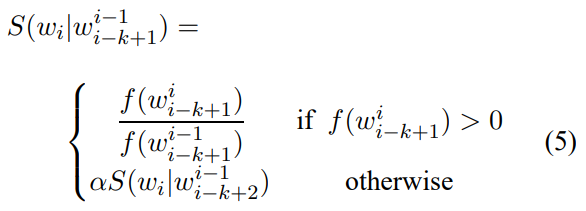

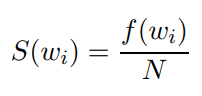

In [63]:
# NLTK StupidBackoff
from nltk.lm import StupidBackoff
import random
from nltk.lm import NgramCounter

In [64]:
# Dataset
macbeth_sents = [[w.lower() for w in sent] for sent in gutenberg.sents('shakespeare-macbeth.txt')]
macbeth_words = flatten(macbeth_sents)

N = 2 # bigrams

# Vocabulary 
lex = Vocabulary(macbeth_words, unk_cutoff=2) # cutoff generates OOV

macbeth_sents_oov = [list(lex.lookup(sent)) for sent in macbeth_sents]
padded_oov, flat_text_oov = padded_everygram_pipeline(N, macbeth_sents_oov)
padded_oov = [[gram for gram in sent] for sent in padded_oov]

# Frequency dist
counter = NgramCounter()
counter.update(padded_oov)

In [65]:
"""
test_sentences = [
    "the tragedie",
    "in thunder",
    "the history of"
]
"""
test_sentences = ["the king is dead"]

**NLTK Stupid Backoff**

In [66]:
# if we feed the vocabulary created above, it performs as bad as with "fit"
nltk_sbackoff_lm = StupidBackoff(order=N, alpha=0.4, counter=counter)
# Somehow, fit leads to worse performance?
# nltk_sbackoff_lm.fit(padded_oov, flat_text_oov)

**Stupid Backoff Implementation**

In [67]:
from nltk.lm.api import LanguageModel

class CustomStupidBackoff:

    def __init__(self, counter, order=2, alpha=0.4):
        """
            alpha    Score coefficient
        """
        self.alpha = alpha
        self.counts = counter
        self.order = order

    
    def score(self, word, context=None):
        """
            Compute backoff score
            input:  word     String
                    context  List
                    ctx_len  Context length
        """
        # Base case
        if context is None or len(context) == 0:
            return self.counts[word] / self.counts.N() # base case
        else:
            # .N() is the equivalent of sum(self.counts[context].values())
            # [len(context)][context] is the context count
            
            f_w_i = self.counts[context][word]
            f_w_i_1 =  self.counts[context].N()

            if f_w_i > 0: return f_w_i / f_w_i_1
            else: return self.alpha * self.score(word, context[1:])

    def logscore(self, word, context=None):
        """
            Logarithmic scale of score
        """
        score = self.score(word, context)
        if score == 0: return 0 # prevent blowup
        else: return np.log(score)

In [69]:
my_sbackoff_lm = CustomStupidBackoff(counter, order=N, alpha=0.4)

**Evaluating the models**

In [70]:
def compute_ppl(model, data):
    highest_ngram = model.order
    scores = [] 
    for sentence in data:
        ngrams, flat_text = padded_everygram_pipeline(highest_ngram, [sentence.split()])
        scores.extend([-1 * model.logscore(w[-1], w[0:-1]) for gen in ngrams for w in gen if len(w) == highest_ngram])
    
    return math.pow(2.0, np.asarray(scores).mean())

In [71]:
# My custom backoff algorithm
compute_ppl(my_sbackoff_lm, test_sentences)

18.221965725639464

In [72]:
# NLTK backoff algorithm
compute_ppl(nltk_sbackoff_lm, test_sentences)

12.851851851851851